In [1]:
import seaborn as sns
import spacy
import nltk
from nltk import bigrams
#from nltk.corpus import stopwords
import pandas as pd
import itertools
import collections
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from textblob import TextBlob
import numpy as np
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import datetime
import matplotlib.dates as mdates 

In [93]:
# input tweets from pickle file (They have been cleaned allready)
tweets_t = pd.read_pickle("/Users/tomashegewisch/Desktop/all_6_months_2.pkl")
tweets = pd.read_json('/Users/tomashegewisch/Downloads/hashtags-20200301-20201109_v2.json', lines=True, orient='record')
d1 = "2020-03-01"
d2 = "2020-08-31"
def get_date_range_for_tweet(date):
    date_1 = datetime.datetime.strptime(d1,'%Y-%m-%d')
    date_2 = datetime.datetime.strptime(d2,'%Y-%m-%d')
    date = date.to_pydatetime().strftime("%Y-%m-%d")
    date = datetime.datetime.strptime(date,'%Y-%m-%d')
    if date >= date_1 and date <= date_2:
        return True
    else:
        return False
# Remove tweets that are out of the date range 
tweets = tweets[tweets['date'].apply(lambda x : get_date_range_for_tweet(x)) == True]

In [3]:
# Create a dataframe from all the words that have been tokenised
word_list = [] 
for i in tweets_t['tokenised']:
    for j in i:
        if j != "amp":
            word_list.append(j)
word_list = pd.DataFrame(word_list)

KeyError: 'tokenised'

In [ ]:
#This is no-longer used
# # Process a Sentimnet value for each tweet.
# def get_sent(text):
#     return TextBlob(text).sentiment.polarity

# tweets['senti_values'] = tweets['tweet_clean'].apply(lambda x : get_sent(x))

In [94]:
# sentimnet score was crected by Richards using https://stanfordnlp.github.io/stanza/sentiment.html
sentimnet = pd.read_csv('/Users/tomashegewisch/research_project/Tomas/data/sentiment.csv') 
tweets = tweets.join(sentimnet.set_index('id'), on='id', how='inner')
tweets = tweets.rename(columns={'sentiment': 'senti_values'})

In [95]:
tweets.shape

(123921, 37)

In [85]:
# Create bar chart showing Sentimnet for the top 10 most common words.
word_list_counter = Counter(word_list[0])
def get_sent_for_top_words(text, lookout_word):
    if lookout_word not in text:
        return None
    else:
        return TextBlob(text).sentiment.polarity

for i in word_list_counter.most_common(10):
    tweet_senti_values = tweets_t['tweet_clean'].apply(lambda x : get_sent_for_top_words(x, i[0]))
    tweet_senti_values = tweet_senti_values.dropna(axis=0, inplace=False, how=None)
    #tweet_senti_values.hist()
    plt.hist(tweet_senti_values)
    plt.title('Sentiment around the word: ' + i[0])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/barchart/barchart_Sentiment_"+i[0]+".png")
    plt.clf()

IndexError: list index out of range

In [9]:
# https://stackoverflow.com/a/1060330
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

def build_dt(df):
    start_date = datetime.date(2020, 3, 1)
    end_date = datetime.date(2020, 9, 1)

    for date in daterange(start_date, end_date):
        yield date, sum(df['date'] == date.strftime("%Y-%m-%d"))
def build_dt1(df, ocol):
    start_date = datetime.date(2020, 3, 1)
    end_date = datetime.date(2020, 9, 1)

    for date in daterange(start_date, end_date):
        try:
            yield date, sum(df.loc[df['date'] == date.strftime("%Y-%m-%d"), ocol]) / sum(df['date'] == date.strftime("%Y-%m-%d"))
        except:
            yield date, 0
# sns.lineplot(data=pd.DataFrame(build_dt(tweets), columns=['date', 'count']), x='date', y='count')

In [7]:
negative, neutral, and positive

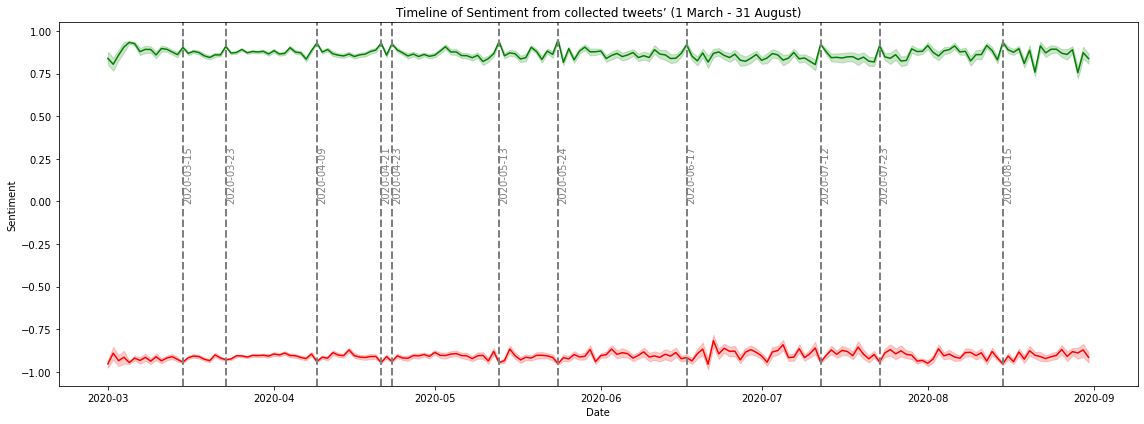

<Figure size 432x288 with 0 Axes>

In [136]:
# The entire sentimnet values for the 6 months.
tweets['sentiment_type'] = 'Neutral'
tweets.loc[tweets['senti_values'] > 0, 'sentiment_type'] = 'Positive'
tweets.loc[tweets['senti_values'] < 0, 'sentiment_type'] = 'Negative'



plt.figure(figsize=(16, 6))
sns.lineplot(data=tweets[tweets['sentiment_type'] != 'Neutral'].rename(columns={"senti_values": "Sentiment","date":"Date"}),
             x='Date',
             y='Sentiment',
             hue='sentiment_type', 
             palette=['green', 'red'], 
             legend=False, ci=68).set_title("Timeline of Sentiment from collected tweets’ (1 March - 31 August)").get_figure()
pres_speaks_dates =[
    '2020-03-15',
    '2020-03-23',
    '2020-04-09',
    '2020-04-21',
    '2020-04-23',
    '2020-05-13',
    '2020-05-24',
    '2020-06-17',
    '2020-07-12',
    '2020-07-23',
    '2020-08-15']

for i in pres_speaks_dates:
    plt.axvline(i, c='grey', ls = "--", lw = 2)
    plt.text(i,0,i,rotation=90, c = "grey")
plt.tight_layout()
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Sentiment_Timeline of sentiment from collected tweets.png")
plt.show()
plt.clf()

6.5 cyrilramaphosa
9.966749450759378


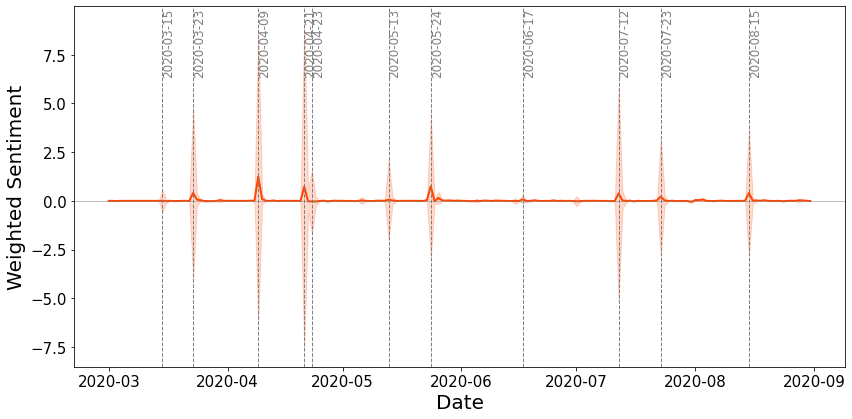

<class 'matplotlib.axes._subplots.AxesSubplot'>


<Figure size 432x288 with 0 Axes>

In [219]:
def hashtags(hashtag, pos):
    print(pos, hashtag)
    tweetsl = tweets[tweets['hashtags'].apply(lambda x: hashtag in x)]
    ps = pd.DataFrame(build_dt1(tweetsl[tweetsl['sentiment_type'] == 'Positive'], 'senti_values'), columns=['date', 'senti_values'])
    ps['count'] = pd.DataFrame(build_dt(tweetsl[tweetsl['sentiment_type'] == 'Positive']), columns=['date', 'count'])['count']
    ptotal = sum(ps['count'])
    ps['type'] = 'Positive'

    ns = pd.DataFrame(build_dt1(tweetsl[tweetsl['sentiment_type'] == 'Negative'], 'senti_values'), columns=['date', 'senti_values'])
    ns['count'] = pd.DataFrame(build_dt(tweetsl[tweetsl['sentiment_type'] == 'Negative']), columns=['date', 'count'])['count']
    ntotal = sum(ns['count'])
    ns['type'] = 'Negative'

#     ps['weighted'] = ps['sentiment'] * (ps['count'] / (ptotal + ntotal)) * 100
#     ns['weighted'] = ns['sentiment'] * (ns['count'] / (ptotal + ntotal)) * 100
#     print(sum((ps['count'] / (ptotal + ntotal)) * 100))

    sent_combined = ps.append(ns)
#   print(sent_combined[sent_combined['weighted'] > 1])
    sent_combined['weighted'] = sent_combined['senti_values'] * (sent_combined['count'] / sum(sent_combined['count']) * 100)
    print(sum(sent_combined['weighted']))
    plt.figure(figsize=(12, 6))
    p = sns.lineplot(data=sent_combined.rename(columns={"weighted": "Weighted","date":"Date"}), 
                     x='Date', 
                     y='Weighted',
                     color = 'orangered',
                    linewidth = 2)
    #, hue='type')
    p.axhline(0, color='grey', lw=0.5)
    p.tick_params(labelsize=15)
    p.set_xlabel("Date",fontsize=20)
    p.set_ylabel("Weighted Sentiment",fontsize=20)
    
    pres_speaks_dates =[
    '2020-03-15',
    '2020-03-23',
    '2020-04-09',
    '2020-04-21',
    '2020-04-23',
    '2020-05-13',
    '2020-05-24',
    '2020-06-17',
    '2020-07-12',
    '2020-07-23',
    '2020-08-15']

    for i in pres_speaks_dates:
        plt.axvline(i, c='grey', ls = "--", lw = 1)
        plt.text(i,pos,i,rotation=90, c = "grey", fontsize=12)
    plt.tight_layout()
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/hastag_sentiment/hastag_Sentiment_"+hashtag+"_AllMonths.png", dpi=300)
    plt.show()
    plt.clf()
    
    print(type(p))
    
list_of_hastages_to_process = [['covid19',0.6], 
['southafrica',0.75], 
['lockdownsa',2.4], 
['cyrilramaphosa',6.6], 
['lockdown',1.2], 
['covid19sa',2.3],
['coronavirussa',6],
['covid_19',1.5], 
['lockdownsouthafrica',4],
['government',-4.5], 
['cigaretteban',-4.5], 
['alcoholban',-4]]

list_of_hastages_to_process = [['cyrilramaphosa',6.5]]
for i in list_of_hastages_to_process:
    hashtags(i[0], i[1])

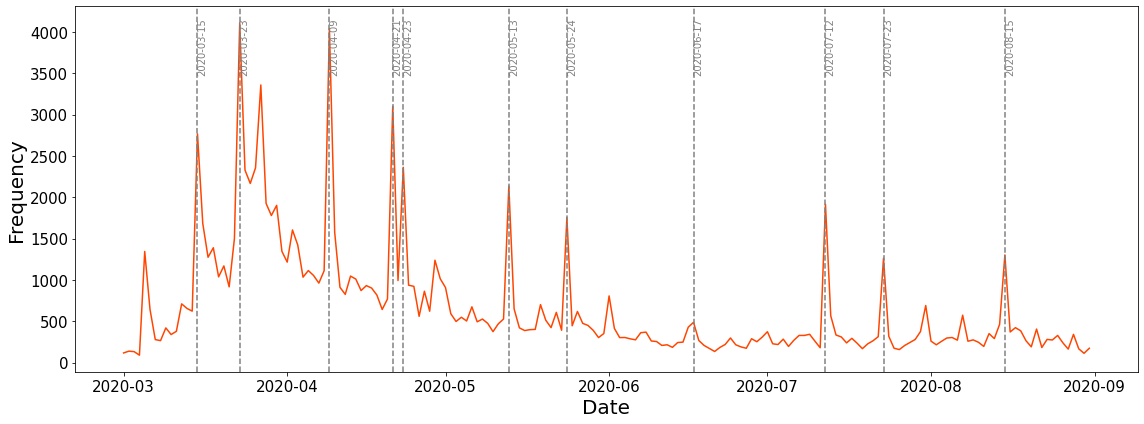

<Figure size 432x288 with 0 Axes>

In [217]:
#Frequency of posting
# https://stackoverflow.com/a/1060330
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)
def build_dt(df):
    start_date = datetime.date(2020, 3, 1)
    end_date = datetime.date(2020, 9, 1)
    for date in daterange(start_date, end_date):
        yield date, sum(df['date'] == date.strftime("%Y-%m-%d"))
        
#post_feq = tweets.groupby('date', as_index=False).size()
post_feq = pd.DataFrame(build_dt(tweets[tweets['hashtags'].apply(lambda x: True)]), columns=['date', 'count'])

plt.figure(figsize=(16, 6))
p = sns.lineplot(data=post_feq, 
                     x='date', 
                     y='count',
                     color = 'orangered')

p.tick_params(labelsize=15)
p.set_xlabel("Date",fontsize=20)
p.set_ylabel("Frequency",fontsize=20)

pres_speaks_dates =[
'2020-03-15',
'2020-03-23',
'2020-04-09',
'2020-04-21',
'2020-04-23',
'2020-05-13',
'2020-05-24',
'2020-06-17',
'2020-07-12',
'2020-07-23',
'2020-08-15']

for i in pres_speaks_dates:
    plt.axvline(i, c='grey', ls = "--")
    plt.text(i,3500,i,rotation=90, c = "grey")
    
plt.tight_layout()
plt.show()
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/all_tweet_frequency.png", dpi=300)
plt.clf()

In [13]:
# covid theamed hastages 
# lockdown theamed hastages.


AttributeError: 'NoneType' object has no attribute 'get_figure'

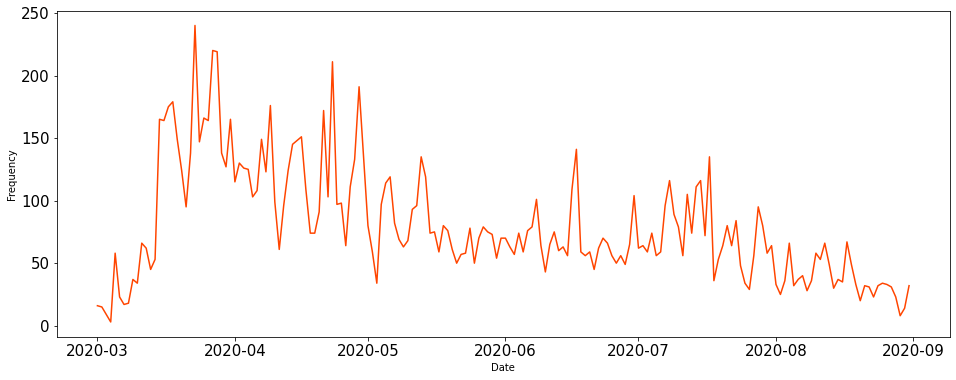

In [206]:
# plot the timeline frequency for popular hastags for the 6 months. 
def get_time_line_of_hastages(find_word, pos):
    def get_if_hastag(htags_list):
        for i in htags_list:
            if i == find_word:
                return True
        return False
    specific_hastage_tweets = tweets[tweets['hashtags'].apply(lambda x : get_if_hastag(x)) == True]
    post_feq = pd.DataFrame(build_dt(specific_hastage_tweets), columns=['date', 'count'])
    
    plt.figure(figsize=(16, 6))
    p = sns.lineplot(x='Date',
                 y='Frequency',
                color = 'orangered',
                 data=post_feq.rename(columns={"count": "Frequency","date":"Date"})).tick_params(labelsize=15)
    #.get_figure().set_xlabel("Date",fontsize=20)
#     p.axhline(0, color='black', lw=2)
#     p.set_xlabel("Date",fontsize=20)
#     p.set_ylabel("Frequency",fontsize=20)
#     .set_title("Frequency for: "+str(find_word)).get_figure().autofmt_xdate()
    pres_speaks_dates =[
    '2020-03-15',
    '2020-03-23',
    '2020-04-09',
    '2020-04-21',
    '2020-04-23',
    '2020-05-13',
    '2020-05-24',
    '2020-06-17',
    '2020-07-12',
    '2020-07-23',
    '2020-08-15']

    for i in pres_speaks_dates:
        plt.axvline(i, c='grey', ls = "--", label = str(i))
        plt.text(i,pos,i,rotation=90, c = "grey")
    
    plt.tight_layout()
    print("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_"+str(find_word)+".png")
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_"+str(find_word)+".png", dpi=300)
    plt.show()
    plt.clf()
    
list_of_hastages_to_process = [['covid19',200], 
['southafrica',170], 
['lockdownsa',790], 
['cyrilramaphosa',1500], 
['lockdown',250], 
['covid19sa',400],
['coronavirussa',1180],
['covid_19',200], 
['lockdownsouthafrica',500],
['government',3.0],
['cigaretteban',35], 
['alcoholban',100]]

#list_of_hastages_to_process = ['lockdown']

for i in list_of_hastages_to_process:
    get_time_line_of_hastages(i[0],i[1])

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_['lockdown', 'lockdownsa', 'lockdownsouthafrica'].png


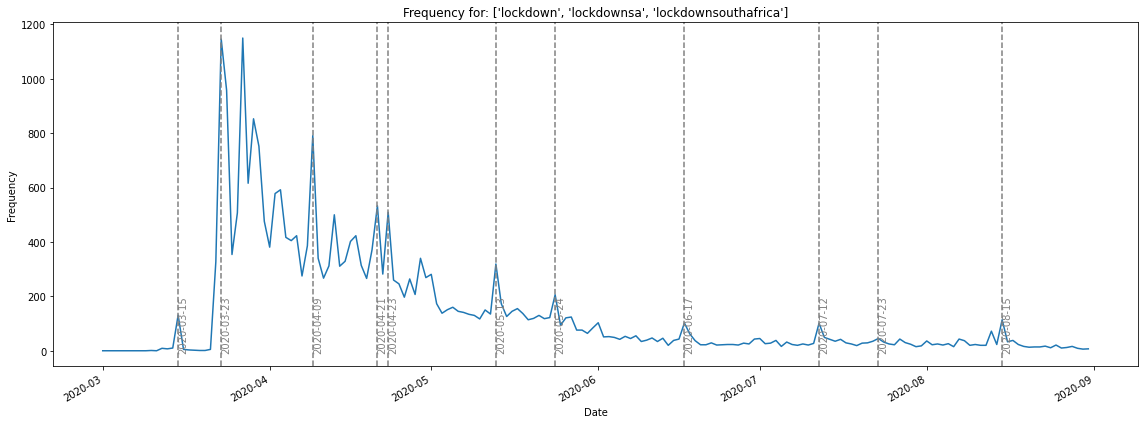

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_['covid19', 'covid_19', 'covid19sa', 'coronavirussa'].png


<Figure size 432x288 with 0 Axes>

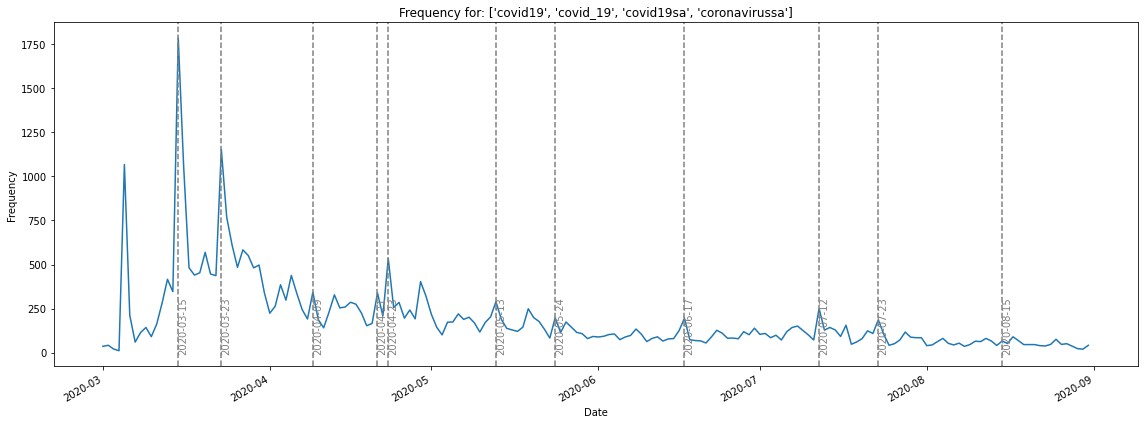

<Figure size 432x288 with 0 Axes>

In [211]:
# we are going to combine things togetehr. 
# plot the timeline frequency for popular hastags for the 6 months. 
#

tweets['hashtags'] = tweets['hashtags'].apply(set)
# very nice way of doing things is to make sure thats its in a set.
def subset_hashtags(hashtags):
    return tweets['hashtags'].apply(lambda x: not set(hashtags).isdisjoint(x))

def get_time_line_of_hastages(hashtag_list):
#     specific_hastage_tweets = tweets[tweets['hashtags'].apply(lambda x : get_if_hastag(x)) == True]
    specific_hastage_tweets = tweetsl = tweets[subset_hashtags(hashtag_list)]
    post_feq = pd.DataFrame(build_dt(specific_hastage_tweets), columns=['date', 'count'])
    
    plt.figure(figsize=(16, 6))
    sns.lineplot(x='Date',
                 y='Frequency',
                 data=post_feq.rename(columns={"count": "Frequency","date":"Date"})).set_title("Frequency for: "+str(hashtag_list)).get_figure().autofmt_xdate()
    pres_speaks_dates =[
    '2020-03-15',
    '2020-03-23',
    '2020-04-09',
    '2020-04-21',
    '2020-04-23',
    '2020-05-13',
    '2020-05-24',
    '2020-06-17',
    '2020-07-12',
    '2020-07-23',
    '2020-08-15']

    for i in pres_speaks_dates:
        plt.axvline(i, c='grey', ls = "--", label = str(i))
        plt.text(i,0,i,rotation=90, c = "grey")
    
    plt.tight_layout()
    print("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_"+str(hashtag_list)+".png")
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/combined_frequency/feq_"+str(hashtag_list)+".png", dpi=300)
    plt.show()
    plt.clf()
    
get_time_line_of_hastages(['lockdown', 'lockdownsa', 'lockdownsouthafrica'])
get_time_line_of_hastages(['covid19', 'covid_19', 'covid19sa', 'coronavirussa'])

8.80841038572898


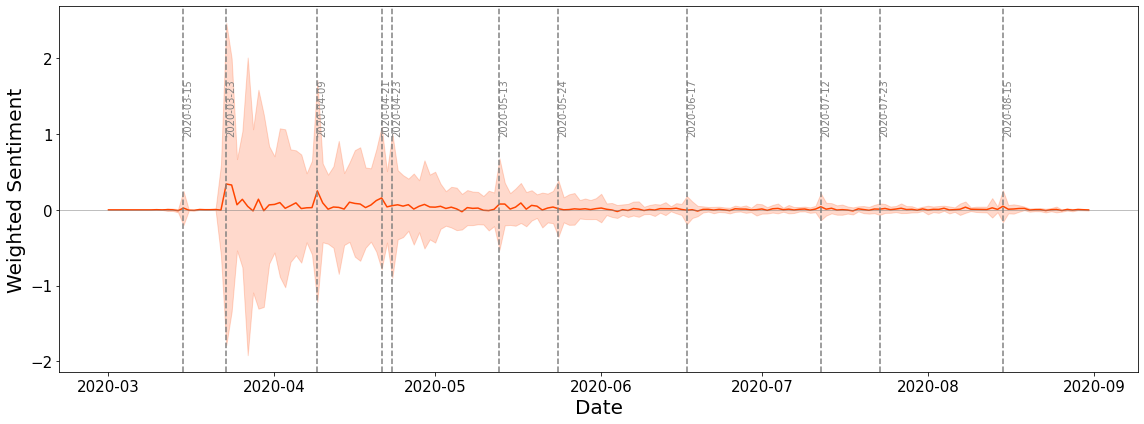

<class 'matplotlib.axes._subplots.AxesSubplot'>
7.262174753261108


<Figure size 432x288 with 0 Axes>

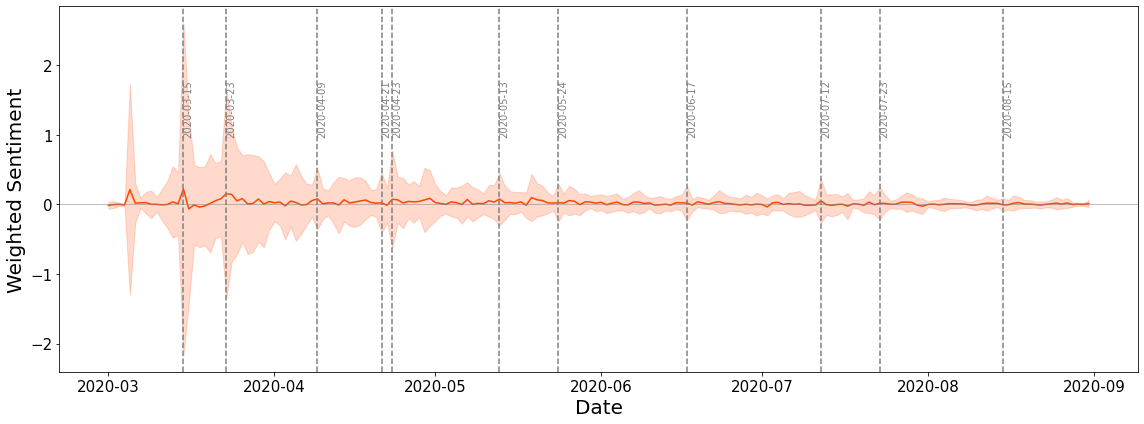

<class 'matplotlib.axes._subplots.AxesSubplot'>


<Figure size 432x288 with 0 Axes>

In [213]:
#ADD groups together for sentimnet

# We will first work on isilating the stuff and then moving forward

tweets['hashtags'] = tweets['hashtags'].apply(set)
# very nice way of doing things is to make sure thats its in a set.
def subset_hashtags(hashtags):
    return tweets['hashtags'].apply(lambda x: not set(hashtags).isdisjoint(x))


def hashtags_to_find(hashtag_list):
#     tweetsl = tweets[tweets['hashtags'].apply(lambda x: hashtag in x)]
    tweetsl = tweets[subset_hashtags(hashtag_list)]
    
    ps = pd.DataFrame(build_dt1(tweetsl[tweetsl['sentiment_type'] == 'Positive'], 'senti_values'), columns=['date', 'senti_values'])
    ps['count'] = pd.DataFrame(build_dt(tweetsl[tweetsl['sentiment_type'] == 'Positive']), columns=['date', 'count'])['count']
    ptotal = sum(ps['count'])
    ps['type'] = 'Positive'

    ns = pd.DataFrame(build_dt1(tweetsl[tweetsl['sentiment_type'] == 'Negative'], 'senti_values'), columns=['date', 'senti_values'])
    ns['count'] = pd.DataFrame(build_dt(tweetsl[tweetsl['sentiment_type'] == 'Negative']), columns=['date', 'count'])['count']
    ntotal = sum(ns['count'])
    ns['type'] = 'Negative'

#     ps['weighted'] = ps['sentiment'] * (ps['count'] / (ptotal + ntotal)) * 100
#     ns['weighted'] = ns['sentiment'] * (ns['count'] / (ptotal + ntotal)) * 100
#     print(sum((ps['count'] / (ptotal + ntotal)) * 100))

    sent_combined = ps.append(ns)
#     print(sent_combined[sent_combined['weighted'] > 1])
    sent_combined['weighted'] = sent_combined['senti_values'] * (sent_combined['count'] / sum(sent_combined['count']) * 100)
    print(sum(sent_combined['weighted']))
    plt.figure(figsize=(16, 6))
    p = sns.lineplot(data=sent_combined.rename(columns={"weighted": "Weighted","date":"Date"}), 
                     x='Date', 
                     y='Weighted',
                    color = "orangered")#, hue='type')
    
    p.axhline(0, color='grey', lw=0.5)
    p.tick_params(labelsize=15)
    p.set_xlabel("Date",fontsize=20)
    p.set_ylabel("Weighted Sentiment",fontsize=20)
    pres_speaks_dates =[
    '2020-03-15',
    '2020-03-23',
    '2020-04-09',
    '2020-04-21',
    '2020-04-23',
    '2020-05-13',
    '2020-05-24',
    '2020-06-17',
    '2020-07-12',
    '2020-07-23',
    '2020-08-15']

    for i in pres_speaks_dates:
        plt.axvline(i, c='grey', ls = "--")
        plt.text(i,1,i,rotation=90, c = "grey")
#     sns.lineplot(x='Date',
#                  y='Polarity',
#                  hue='Key',
#                  data=pd.melt(display_df_average, 
#                               ['date']).rename(columns={"value": "Polarity","variable":"Key", "date":"Date"})).set_title("The Sentiment for of Topic: "+key_word).get_figure().autofmt_xdate()
    plt.tight_layout()
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/combined_hastag_sentiment/hastag_Sentiment_"+str(hashtag_list)+"_combined.png", dpi=300)
    plt.show()
    plt.clf()
    
    print(type(p))

# hashtags_to_find
#covid19, covid_19, covid19sa, coronavirussa
#lockdown, lockdownsa, lockdownsouthafrica
hashtags_to_find(['lockdown', 'lockdownsa', 'lockdownsouthafrica'])
hashtags_to_find(['covid19', 'covid_19', 'covid19sa', 'coronavirussa'])
#tweets[subset_hashtags(['covid19'])]

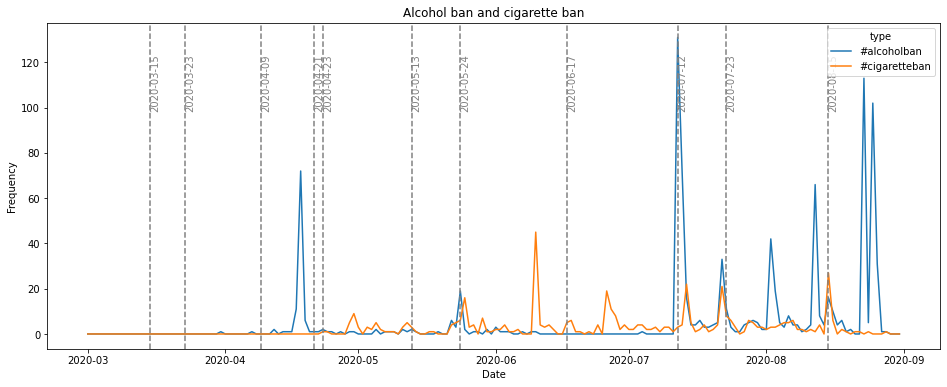

<Figure size 432x288 with 0 Axes>

In [214]:
#Frequency of posting
#cigaretteban
#alcoholban
cb = pd.DataFrame(build_dt(tweets[tweets['hashtags'].apply(lambda x: 'cigaretteban' in x)]), columns=['date', 'count'])
ab = pd.DataFrame(build_dt(tweets[tweets['hashtags'].apply(lambda x: 'alcoholban' in x)]), columns=['date', 'count'])
cb['type'] = '#cigaretteban'
ab['type'] = '#alcoholban'
combined = ab.append(cb)
# combined.loc[combined['type'] == 'cigarette', 'count'] *= -1
plt.figure(figsize=(16, 6))
sns.lineplot(data=combined.rename(columns={'count':'Frequency', 'date':'Date'}), x='Date', y='Frequency', hue='type')

pres_speaks_dates =[
    '2020-03-15',
    '2020-03-23',
    '2020-04-09',
    '2020-04-21',
    '2020-04-23',
    '2020-05-13',
    '2020-05-24',
    '2020-06-17',
    '2020-07-12',
    '2020-07-23',
    '2020-08-15']

for i in pres_speaks_dates:
    plt.axvline(i, c='grey', ls = "--", label = str(i))
    plt.text(i,99,i,rotation=90, c = "grey")
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/hastag_sentiment_overlay/tweet_frequency_cb_ab.png",dpi=300)
plt.show()
plt.clf()

In [ ]:
#Show the collected tweets on a map
places = []
for i in tweets['place']:
    try:
        places.append(i['coordinates'])
    except:
        continue

ruh_m = plt.imread('/Users/tomashegewisch/research_project/Tomas/data/map.png')
map_points = pd.DataFrame(places)
map_points.columns = ['latitude', 'longitude']

#Latitude: -28.4793 Longitude: 24.6727.

fig, ax = plt.subplots(figsize = (11,10))
ax.scatter(map_points.longitude, map_points.latitude, zorder=1, alpha= 1, c='red', s=10)

BBox = ((map_points.longitude.min(),   map_points.longitude.max(),      
         map_points.latitude.min(), map_points.latitude.max()))
#print(BBox)
ax.set_title('Tweet map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.axis("off") 
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/tweet_Map.png",dpi=300)

In [ ]:
#word Cloud all words... no hash tags .. no mentions
from wordcloud import WordCloud, STOPWORDS 
hashtags = []
# #create a list of hashtages
for i in tweets['hashtags']:
    for j in i:
        hashtags.append(j.lower())
        
mentions = []
for i in tweets['mentions']:
    for j in i:
        mentions.append(j['screen_name'].lower())

x = set(word_list[0].tolist())
y = set(hashtags)
x.difference_update(y)
cleaned_words_no_hashtags = list(x)

x2 = set(cleaned_words_no_hashtags)
print(len(x2))
y2 = set(mentions)
x2.difference_update(y2)
print(len(x2))
cleaned_words_no_hashtags = list(x2)

text=" ".join(cleaned_words_no_hashtags)
text=" ".join(word_list[0].tolist())

wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(text)
wordcloud.to_file("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/All_words.png")
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()
#plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/All_words.png")

In [ ]:
# word cloud with negitive sentimnet tweets.
negitive_tweets_words_list = []

for i in range(0, len(tweets)):
    try:
        if tweets['senti_values'][i] < 0:
            for j in tweets['tokenised'][i]:
                negitive_tweets_words_list.append(j)
    except:
        continue

x = set(negitive_tweets_words_list)
y = set(hashtags)
x.difference_update(y)
negitve_words_no_hashtags = list(x)

#cleaned_words_no_hashtags_negitive

text = " ".join(negitve_words_no_hashtags)
wordcloud = WordCloud(width = 1000, height = 800, 
               background_color ='white',  
               min_font_size = 12).generate(text)  
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Only Negative tweet's words", size = 12, color = "black")
plt.tight_layout(pad = 0)
plt.show()
wordcloud.to_file("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/negitive_words.png")
#plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/negitive_words.png")

In [ ]:
# word cloud with negitive positive tweets.
positive_tweets_words_list = []
for i in range(0, len(tweets)):
    try:
        if tweets['senti_values'][i] > 0:
            for j in tweets['tokenised'][i]:
                positive_tweets_words_list.append(j)
    except Exception as e:
        continue
print(len(positive_tweets_words_list))
print(len(hashtags))
x1 = set(positive_tweets_words_list)
y1 = set(hashtags)
x1.difference_update(y1)

text = " ".join(list(x1))

wordcloud = WordCloud(width = 1000, height = 800, 
               background_color ='white',  
               min_font_size = 12).generate(text)  
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Only positive tweet's words", size = 12, color = "black")
plt.tight_layout(pad = 0)
plt.show()
wordcloud.to_file("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/positive_words.png")
#plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/positive_words.png")

In [ ]:
# How many times does this word appear
#word_list_counter
find_words = ["alcohol","cigarettes","ban","government", "ramaphosa", "cyril", "zwelini","mkhize"]
for i in find_words:
    print("The word: ", i, "was found", word_list_counter[i], "times")

In [44]:
word_list_counter.most_common(10)

NameError: name 'word_list_counter' is not defined

In [ ]:
print("There are",len(tweets.user_id.unique().tolist()), "Unique users <user_id>")
print("There are",len(tweets.username.unique().tolist()), "Unique users <name>")
print("The difference between the values happens when someone changes their username")

In [ ]:
print("Top 10 list of the most mentioned Twitter account\n")
for i in Counter([item["name"] for sublist in tweets['mentions'].tolist() for item in sublist]).most_common(10):
    print(i[0] ,i[1])

In [ ]:
time_for_tweeting = []
def get_if_hastag(htags_list, find_word):
    for i in htags_list:
        if i == find_word:
            return True
    return False

def get_time_line(key_word):
    tweets_time = tweets[tweets['hashtags'].apply(lambda x : get_if_hastag(x,key_word)) == True]
    for i in tweets_time['time']:
        time_for_tweeting.append(i.split(":")[0])
    time_df = pd.DataFrame.from_dict((Counter(time_for_tweeting)), orient='index').reset_index()
    time_df = time_df.rename(columns={'index':'Time', 0:'Count'})
    time_df = time_df.sort_values(by=['Time']).reset_index().drop('index', axis=1)
    #sns.set_theme(style="darkgrid")
    plt.figure(figsize=(16, 6))
    ax = sns.barplot(x="Time", y="Count", data=time_df).set_title(key_word)
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/time_of_day/time_of_day_"+key_word+".png")
    plt.show()


list_of_hastages_to_process = ['covid19', 
'southafrica', 
'lockdownsa', 
'cyrilramaphosa', 
'lockdown', 
'covid19sa',
'coronavirussa',
'covid_19', 
'lockdownsouthafrica',
'government',
'cigaretteban', 
'alcoholban']

for i in list_of_hastages_to_process:
    get_time_line(i)

In [78]:
import preprocessor as p
tweets = pd.read_pickle("/Users/tomashegewisch/Desktop/all_6_months_2.pkl")
#p.set_options(p.OPT.URL, p.OPT.EMOJI)
def do_process(text):
    return p.clean(text)
#tweets['new_col'] = tweets['tweet'].apply(do_process)
output = tweets[['id', 'tweet_clean']]
output.to_csv("/Users/tomashegewisch/Desktop/tweets_df.csv", index=False)

In [ ]:
"#government","#covid19","#southafrica","#lockdownsa","#cyrilramaphosa","#lockdown","#covid19sa","#coronavirussa","#covid_19","#lockdownsouthafrica"

In [70]:
test = pd.DataFrame(build_dt(tweets[tweets['hashtags'].apply(lambda x: 'cigaretteban' in x)]), columns=['date', 'count'])
#post_feq = specific_hastage_tweets.groupby('date', as_index=False).size()
#test['count'].max()
test.loc[test['count'].idxmax()]

date     2020-06-10
count            45
Name: 101, dtype: object

In [109]:
# tweets['hashtags'] = tweets['hashtags'].apply(set)
# tweetsl = tweets[subset_hashtags(hashtag_list)]
#(lockdown OR lockdownsa OR lockdownsouthafrica) AND (cigaretteban OR alcoholban)
count = 0
ban = False
lock = False
for i in tweets['hashtags']:
    for j in i:
        if j == "lockdown" or j == "lockdownsa" or j == "lockdownsouthafrica":
            lock= True
        if j == "cigaretteban" or j == "alcoholban":
            ban = True
    if lock == True and ban == True:
        count+=1
    ban = False
    lock = False
print(count)

169


In [163]:
ban = 0 
cig = False
alch = False
for i in range(0, len(tweets['hashtags'])):
    try:
        for j in tweets['hashtags'][i]:
            if j == "alcoholban":
                alch = True
    except:
        print("")
    if alch == True:
        print(tweets['tweet'][i])
    alch = False 
print("The number of times cigaretteban or alcoholban were found in a tweet", ban)

KeyboardInterrupt: 

In [151]:
alchban = 0 
for i in tweets['hashtags']:
    for j in i:
        if j == "alcoholban":
            alchban+= 1
print("The number of times alcoholban were found in a tweet", alchban)

The number of times alcoholban were found in a tweet 949


In [152]:
cigban = 0 
for i in tweets['hashtags']:
    for j in i:
        if j == "cigaretteban": 
            cigban+= 1
print("The number of times cigaretteban were found in a tweet", cigban)

The number of times cigaretteban were found in a tweet 440


In [149]:
print("We have",len(tweets), "tweets")

We have 123921 tweets
